In [63]:
import torch
from torchvision import datasets, transforms
from PixelCNN.model import PixelCNN
from Diffusion.forward import VarianceSchedule
from Diffusion.time_embedding import TimeEmbedding
import pathlib
from PixelCNN.config import Config
from Dataset.random_crop import RandomPaddedCrop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from importlib import reload

In [ ]:
import PixelCNN.config
reload(PixelCNN.config)

import Dataset.random_crop
reload(Dataset.random_crop)

<module 'Dataset.random_crop' from '/mnt/d/Programming/LearnPy/Cars_Diffusion/Dataset/random_crop.py'>

In [34]:
data_dir = pathlib.Path(__vsc_ipynb_file__).parent.resolve() / "Dataset" / "Cars Dataset"
train_dir = data_dir / "train"
test_dir = data_dir / "test"

cfg = Config()

In [52]:
img_transform = transforms.Compose([
    RandomPaddedCrop((256, 256)),
    transforms.TrivialAugmentWide(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [57]:
test_dataset = datasets.ImageFolder(
    test_dir, transform=img_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers
)

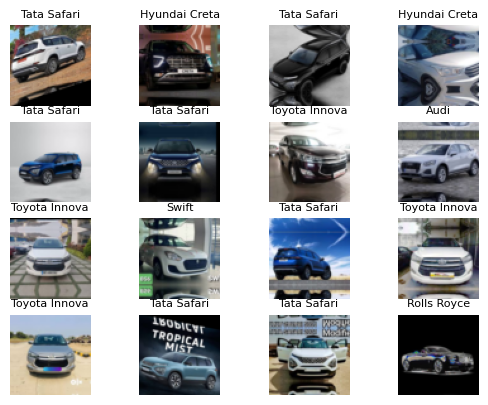

In [61]:
img, label = next(iter(test_loader ))
img = img[:16]


for i in range(img.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i].permute(1, 2, 0))
    plt.title(f"{test_dataset.classes[label[i]]}", fontsize=8)
    plt.axis('off')
plt.show()

In [ ]:
time_embedding = TimeEmbedding(cfg.time_embedding_dim, cfg.embedding_dim, cfg.num_timesteps)

label_embedding = torch.nn.Embedding(len(test_dataset.classes), cfg.embedding_dim)